In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

In [15]:
IMG_SIZE = 64
BATCH_SIZE = 128

In [16]:
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.float32)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [17]:
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),  # Kurangi units
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')  # dtype untuk mixed precision
])

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
start_time = time.time()

In [23]:
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5319 - loss: 0.7227 - val_accuracy: 0.6258 - val_loss: 0.6586
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6284 - loss: 0.6394 - val_accuracy: 0.6935 - val_loss: 0.5781
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7033 - loss: 0.5751 - val_accuracy: 0.7539 - val_loss: 0.5143
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.7381 - loss: 0.5271 - val_accuracy: 0.7767 - val_loss: 0.4646
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7679 - loss: 0.4791 - val_accuracy: 0.7997 - val_loss: 0.4336
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7953 - loss: 0.4417 - val_accuracy: 0.8087 - val_loss: 0.4115
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8016 - loss: 0.4308 - val_accuracy: 0.8091 - val_loss: 0.4068
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8163 - loss: 0.4035 - val_accu

In [24]:
test_loss, test_acc = model.evaluate(ds_test)
print(f"Akurasi Testing: {test_acc * 100:.2f}%")  # Harus >80%

37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 400ms/step - accuracy: 0.8370 - loss: 0.3560
Akurasi Testing: 84.07%


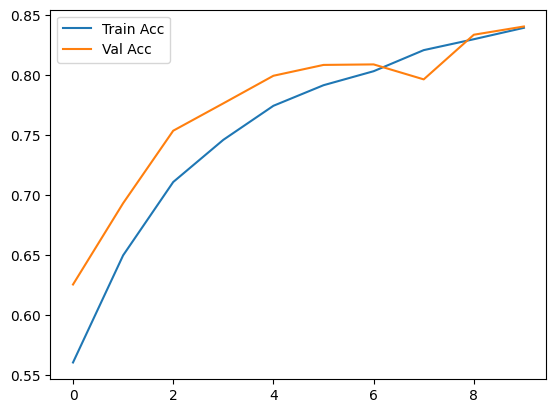

In [25]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()